In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pathlib import Path

# 현재 노트북이 실행되는 경로 기준으로 파일 찾기 (git 업로드 시에도 동작)
def resolve_local_file(filename: str) -> Path:
    base = Path.cwd()
    direct = base / filename
    if direct.exists():
        return direct
    # 대소문자 차이나 확장자 오타 방지용 간단 탐색 (현재 디렉터리 한정)
    for p in base.iterdir():
        if p.is_file() and p.name.lower() == filename.lower():
            return p
    raise FileNotFoundError(f"'{filename}' 파일을 현재 경로({base})에서 찾을 수 없습니다.")

# CSV 파일 로드 (현재 경로에서 찾기)
csv_path = resolve_local_file("tmp.csv")
data = pd.read_csv(csv_path, header=None)
print(f"✓ 온도 데이터 로드 성공: {csv_path}")

# 데이터의 첫 번째 열은 'years', 두 번째 열은 'temper'로 가정
data.columns = ['years', 'temper']

print(f"데이터 크기: {data.shape}")
print(data.head())

# 결측값을 평균값으로 채우기
data['temper'] = data['temper'].fillna(data['temper'].mean())

def predict_temperature_rise(start_year, end_year):
    A = data[['years']].values  # 'years' 컬럼
    B = data['temper'].values   # 'temper' 컬럼

    # 회귀 모델 훈련
    model = LinearRegression()
    model.fit(A, B)

    # 시작 연도와 종료 연도에 대한 예측
    start_temp = model.predict([[start_year]])[0]
    end_temp = model.predict([[end_year]])[0]

    # 온도 차이 계산
    temperature_difference = end_temp - start_temp
    return temperature_difference  # 온도 차이 반환

# 예시: 현재 연도와 나중 연도 입력
start_year = int(input("현재 연도를 쓰세요: "))
end_year = int(input("나중 연도를 쓰세요: "))
rise = predict_temperature_rise(start_year, end_year)

print(f"{start_year}년과 {end_year}년 사이의 온도 상승폭: {rise:.2f}°C")

✓ 온도 데이터 로드 성공: c:\Users\dnalq\Documents\데1\tmp.csv
데이터 크기: (117, 2)
   years  temper
0   1908    10.4
1   1909    10.6
2   1910    10.3
3   1911    10.6
4   1912    10.1
2014년과 2020년 사이의 온도 상승폭: 0.15°C
2014년과 2020년 사이의 온도 상승폭: 0.15°C


##화재피해 머신러닝


Linear Regression1 R2 Score: 0.04
Decision Tree1 R2 Score: -0.60
Random Forest1 R2 Score: 0.06


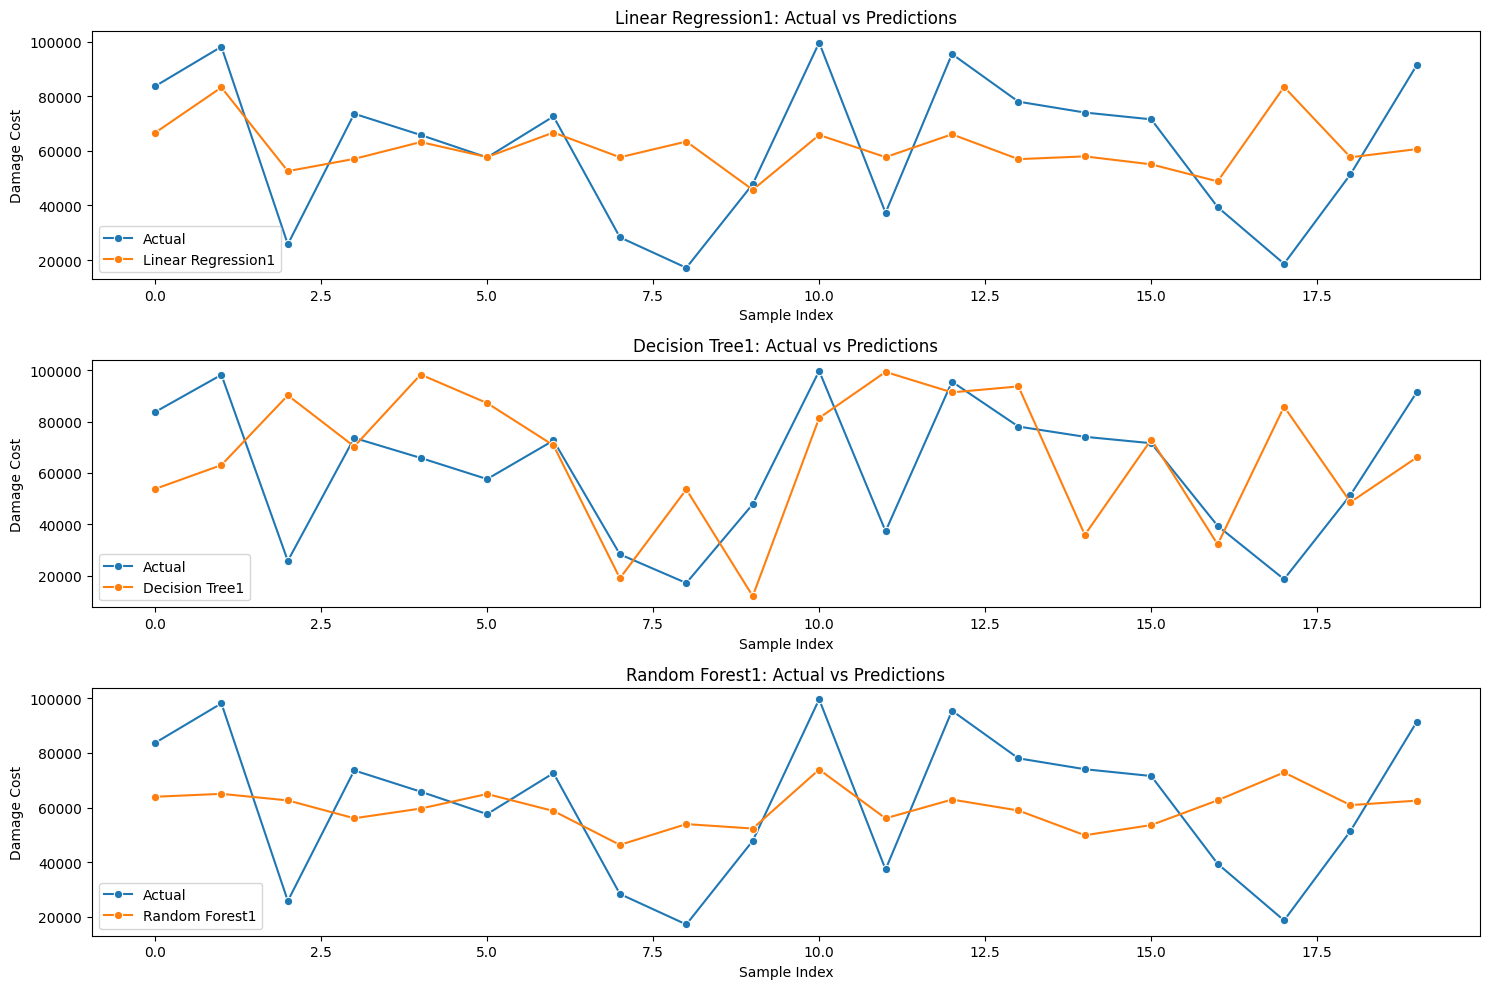

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 시드 고정
np.random.seed(88798)

# 샘플 데이터 생성 (100개 데이터)
data = {
    'structure': np.random.choice(['steel', 'wood', 'concrete'], 100),
    'housing_type': np.random.choice(['apartment', 'villa', 'detached'], 100),
    'area': np.random.randint(50, 200, 100),
    'approval_year': np.random.randint(1980, 2022, 100),
    'floor_area_ratio': np.random.uniform(0.5, 2.0, 100),
    'location': np.random.choice(['dong1', 'dong2', 'dong3'], 100),
    'temperature': np.random.uniform(15, 35, 100),
    'humidity': np.random.uniform(30, 80, 100),
    'damage_cost': np.random.randint(10000, 100000, 100)
}

# 데이터프레임 생성
df1 = pd.DataFrame(data)

# 범주형 변수 원핫 인코딩
categorical_columns1 = ['structure', 'housing_type', 'location']
onehot_encoder1 = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded1 = onehot_encoder1.fit_transform(df1[categorical_columns1])
onehot_df1 = pd.DataFrame(onehot_encoded1, columns=onehot_encoder1.get_feature_names_out(categorical_columns1))

# 수치형 변수 처리 (데이터를 바탕으로 임계값 계산)
def bin_variable1(column, bins):
    return np.digitize(column, bins)

def calculate_bins1(column, num_bins):
    return np.linspace(column.min(), column.max(), num_bins + 1)[1:-1]

# 연면적, 사용승인일, 용적률, 온도, 습도 임계값 계산 및 변환
df1['area_binned'] = bin_variable1(df1['area'], calculate_bins1(df1['area'], 3))
df1['approval_binned'] = bin_variable1(df1['approval_year'], calculate_bins1(df1['approval_year'], 4))
df1['floor_area_ratio_binned'] = bin_variable1(df1['floor_area_ratio'], calculate_bins1(df1['floor_area_ratio'], 3))
df1['temperature_binned'] = bin_variable1(df1['temperature'], calculate_bins1(df1['temperature'], 3))
df1['humidity_binned'] = bin_variable1(df1['humidity'], calculate_bins1(df1['humidity'], 3))

# 독립변수 및 종속변수 설정
X1 = pd.concat([
    onehot_df1,
    df1[['area_binned', 'approval_binned', 'floor_area_ratio_binned', 'temperature_binned', 'humidity_binned']]
], axis=1)

Y1 = df1['damage_cost']

# 데이터셋 분리
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=42)

# 스케일링 (화재 전용)
scaler_fire = StandardScaler()
X_train_scaled1 = scaler_fire.fit_transform(X_train1)
X_test_scaled1 = scaler_fire.transform(X_test1)

# 1. 다중 선형 회귀
linear_model1 = LinearRegression()

# 2. 의사결정트리
tree_model1 = DecisionTreeRegressor(random_state=42)
# 3. 랜덤포레스트
forest_model1 = RandomForestRegressor(random_state=42, n_estimators=100)
# 모델 학습 (모든 모델에 스케일링된 X 사용)
linear_model1.fit(X_train_scaled1, Y_train1)
tree_model1.fit(X_train_scaled1, Y_train1)
forest_model1.fit(X_train_scaled1, Y_train1)

# 모델 예측
linear_preds1 = linear_model1.predict(X_test_scaled1)
tree_preds1 = tree_model1.predict(X_test_scaled1)
forest_preds1 = forest_model1.predict(X_test_scaled1)

# 모델 평가
results = {}
results['Linear Regression1'] = linear_model1.score(X_test_scaled1, Y_test1)
results['Decision Tree1'] = tree_model1.score(X_test_scaled1, Y_test1)
results['Random Forest1'] = forest_model1.score(X_test_scaled1, Y_test1)

# 결과 출력
for model_name, score in results.items():
    print(f"{model_name} R2 Score: {score:.2f}")

# 모델별 실제값과 예측값 비교 시각화
plt.figure(figsize=(15, 10))

# 1. 선형 회귀
plt.subplot(3, 1, 1)
sns.lineplot(x=range(len(Y_test1)), y=Y_test1.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test1)), y=linear_preds1, label="Linear Regression1", marker="o")
plt.title("Linear Regression1: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

# 2. 의사결정 트리
plt.subplot(3, 1, 2)
sns.lineplot(x=range(len(Y_test1)), y=Y_test1.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test1)), y=tree_preds1, label="Decision Tree1", marker="o")
plt.title("Decision Tree1: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

# 3. 랜덤 포레스트
plt.subplot(3, 1, 3)
sns.lineplot(x=range(len(Y_test1)), y=Y_test1.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test1)), y=forest_preds1, label="Random Forest1", marker="o")
plt.title("Random Forest1: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

plt.tight_layout()
plt.show()


##침수피해 머신러닝


Linear Regression R2 Score: -0.02
Decision Tree R2 Score: -1.01
Random Forest R2 Score: 0.03


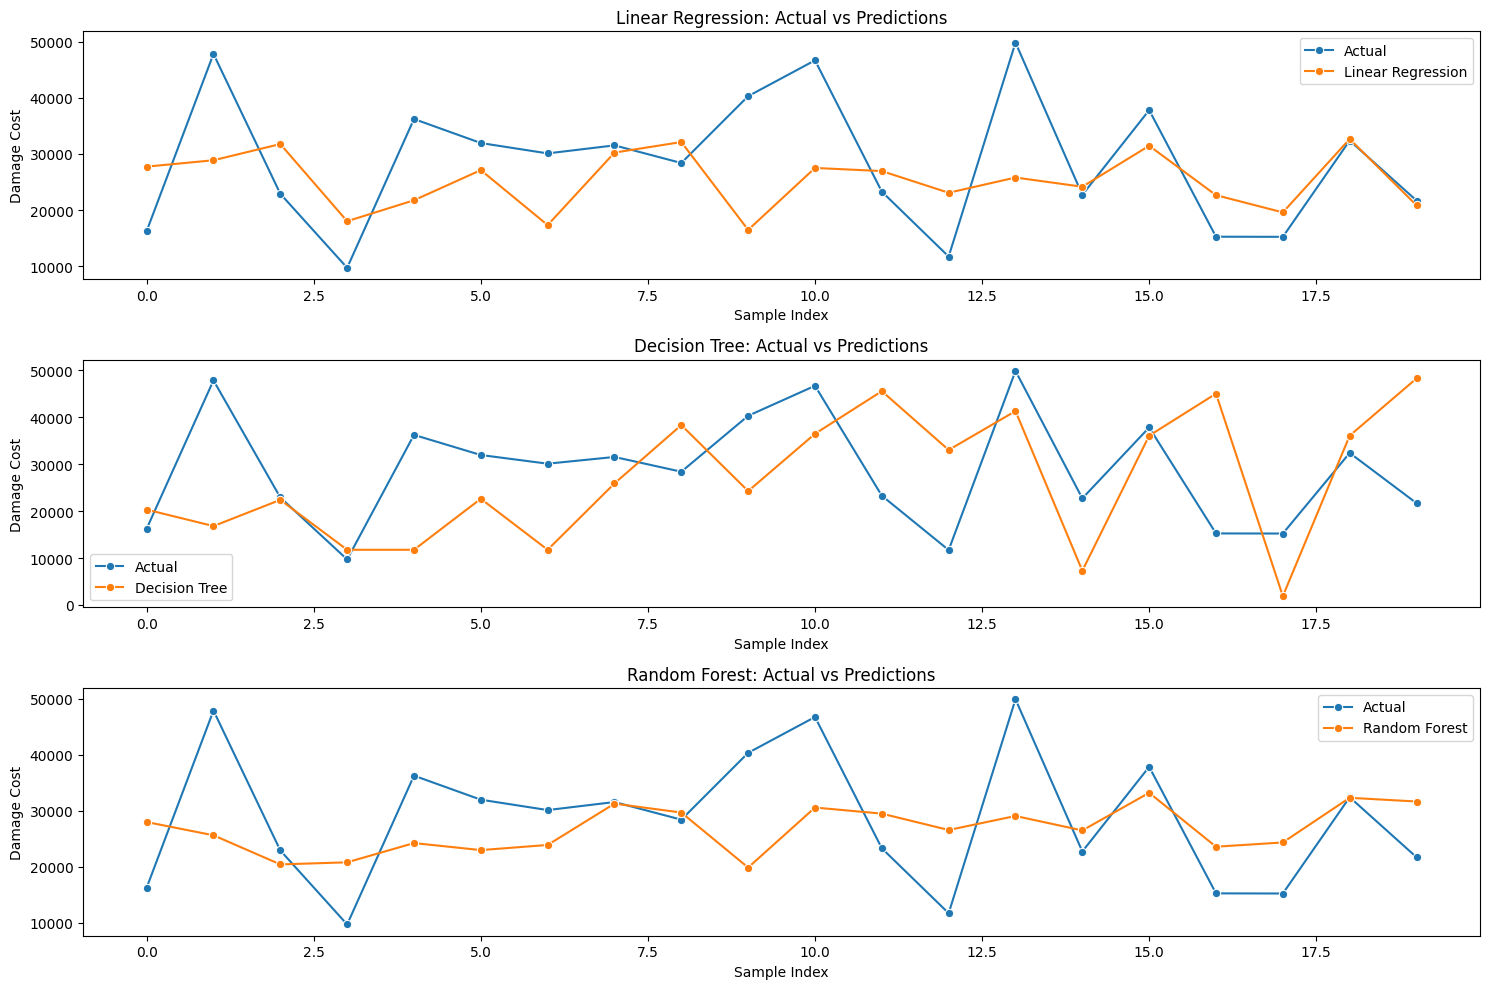

In [10]:
# 시드 고정
np.random.seed(483)
# 샘플 데이터 생성 (30개 데이터)
data = {
    'structure': np.random.choice(['steel', 'wood', 'concrete'], 100),
    'housing_type': np.random.choice(['apartment', 'villa', 'detached'], 100),
    'land_use': np.random.choice(['residential', 'commercial', 'industrial'], 100),
    'land_area': np.random.randint(100, 1000, 100),
    'approval_year': np.random.randint(1980, 2022, 100),
    'basement_floors': np.random.randint(0, 5, 100),
    'slope': np.random.uniform(0, 30, 100),
    'distance_to_river': np.random.uniform(0.1, 5.0, 100),
    'elevation': np.random.randint(1, 500, 100),
    'temperatures': np.random.uniform(15, 35, 100),
    'flood_damage_cost': np.random.randint(1000, 50000, 100)
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 범주형 변수 원핫 인코딩
categorical_columns = ['structure', 'housing_type', 'land_use']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(df[categorical_columns])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# 수치형 변수 처리 (데이터를 바탕으로 임계값 계산)
def bin_variable(column, bins):
    return np.digitize(column, bins)

def calculate_bins(column, num_bins):
    return np.linspace(column.min(), column.max(), num_bins + 1)[1:-1]

# 대지면적, 사용승인일, 지하층수, 경사도, 하천과의 거리, 고도 임계값 계산 및 변환
df['land_area_binned'] = bin_variable(df['land_area'], calculate_bins(df['land_area'], 4))
df['approval_binned'] = bin_variable(df['approval_year'], calculate_bins(df['approval_year'], 4))
df['basement_binned'] = bin_variable(df['basement_floors'], calculate_bins(df['basement_floors'], 3))
df['slope_binned'] = bin_variable(df['slope'], calculate_bins(df['slope'], 3))
df['distance_binned'] = bin_variable(df['distance_to_river'], calculate_bins(df['distance_to_river'], 3))
df['elevation_binned'] = bin_variable(df['elevation'], calculate_bins(df['elevation'], 4))
df['temperatures_binned'] = bin_variable(df['temperatures'], calculate_bins(df['temperatures'], 3))

# 독립변수 및 종속변수 설정
X = pd.concat([
    onehot_df,
    df[['land_area_binned', 'approval_binned', 'basement_binned', 'slope_binned', 'distance_binned', 'elevation_binned', 'temperatures_binned']]
], axis=1)

Y = df['flood_damage_cost']

# 데이터셋 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. 다중 선형 회귀
linear_model = LinearRegression()

# 2. 의사결정트리
tree_model = DecisionTreeRegressor(random_state=42)

# 3. 랜덤포레스트
forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
# 모델 학습 (모든 모델에 스케일링된 X 사용)
linear_model.fit(X_train_scaled, Y_train)
tree_model.fit(X_train_scaled, Y_train)
forest_model.fit(X_train_scaled, Y_train)

# 모델 예측
linear_preds = linear_model.predict(X_test_scaled)
tree_preds = tree_model.predict(X_test_scaled)
forest_preds = forest_model.predict(X_test_scaled)

# 모델 평가
results = {}
results['Linear Regression'] = linear_model.score(X_test_scaled, Y_test)
results['Decision Tree'] = tree_model.score(X_test_scaled, Y_test)
results['Random Forest'] = forest_model.score(X_test_scaled, Y_test)

# 결과 출력
for model_name, score in results.items():
    print(f"{model_name} R2 Score: {score:.2f}")

# 모델별 실제값과 예측값 비교 시각화
plt.figure(figsize=(15, 10))

# 1. 선형 회귀
plt.subplot(3, 1, 1)
sns.lineplot(x=range(len(Y_test)), y=Y_test.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test)), y=linear_preds, label="Linear Regression", marker="o")
plt.title("Linear Regression: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

# 2. 의사결정 트리
plt.subplot(3, 1, 2)
sns.lineplot(x=range(len(Y_test)), y=Y_test.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test)), y=tree_preds, label="Decision Tree", marker="o")
plt.title("Decision Tree: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

# 3. 랜덤 포레스트
plt.subplot(3, 1, 3)
sns.lineplot(x=range(len(Y_test)), y=Y_test.values, label="Actual", marker="o")
sns.lineplot(x=range(len(Y_test)), y=forest_preds, label="Random Forest", marker="o")
plt.title("Random Forest: Actual vs Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Damage Cost")
plt.legend()

plt.tight_layout()
plt.show()



##침수피해예측함수

In [11]:
def predict_flood_damage():
    # 사용자로부터 입력받기
    print("각 칼럼에 대해 값을 입력해주세요.")

    structure = input("Structure (steel, wood, concrete): ").strip()
    housing_type = input("Housing Type (apartment, villa, detached): ").strip()
    land_use = input("Land Use (residential, commercial, industrial): ").strip()
    land_area = float(input("Land Area (숫자 입력): ").strip())
    approval_year = int(input("Approval Year (연도 입력, 예: 1990): ").strip())
    basement_floors = int(input("Basement Floors (숫자 입력, 예: 2): ").strip())
    slope = float(input("Slope (숫자 입력, 예: 15.0): ").strip())
    distance_to_river = float(input("Distance to River (숫자 입력, 예: 3.5): ").strip())
    elevation = int(input("Elevation (숫자 입력, 예: 100): ").strip())
    temperatures = float(input("Temperatures (숫자 입력, 예: 25.0): ").strip())

    # 범주형 변수 원핫 인코딩 처리
    input_df = pd.DataFrame({
        'structure': [structure],
        'housing_type': [housing_type],
        'land_use': [land_use],
        'land_area': [land_area],
        'approval_year': [approval_year],
        'basement_floors': [basement_floors],
        'slope': [slope],
        'distance_to_river': [distance_to_river],
        'elevation': [elevation],
        'temperatures': [temperatures + rise]
    })

    # 원핫 인코딩 처리
    onehot_encoded_input = onehot_encoder.transform(input_df[['structure', 'housing_type', 'land_use']])
    onehot_df_input = pd.DataFrame(onehot_encoded_input, columns=onehot_encoder.get_feature_names_out(['structure', 'housing_type', 'land_use']))

    # 수치형 변수 임계값 처리 (이전에 계산한 임계값을 기준으로 처리)
    bins_dict = {
        'land_area': calculate_bins(df['land_area'], 4),
        'approval_year': calculate_bins(df['approval_year'], 4),
        'basement_floors': calculate_bins(df['basement_floors'], 3),
        'slope': calculate_bins(df['slope'], 3),
        'distance_to_river': calculate_bins(df['distance_to_river'], 3),
        'elevation': calculate_bins(df['elevation'], 4),
        'temperatures': calculate_bins(df['temperatures'], 4)
    }

    binned_data = [
        bin_variable([land_area], bins_dict['land_area'])[0],
        bin_variable([approval_year], bins_dict['approval_year'])[0],
        bin_variable([basement_floors], bins_dict['basement_floors'])[0],
        bin_variable([slope], bins_dict['slope'])[0],
        bin_variable([distance_to_river], bins_dict['distance_to_river'])[0],
        bin_variable([elevation], bins_dict['elevation'])[0],
        bin_variable([temperatures], bins_dict['temperatures'])[0]
    ]

    # 원핫 인코딩된 데이터와 binned 데이터를 합침
    final_input_values = np.concatenate([onehot_df_input.values[0], binned_data])
    final_input = pd.DataFrame([final_input_values], columns=X.columns)

    # 예측 - 훈련된 scaler 재사용
    input_scaled = scaler.transform(final_input)
    predicted_damage_cost = forest_model.predict(input_scaled)

    return predicted_damage_cost[0]

##화재피해예측함수

In [12]:
# 화재 피해 예측 함수
def predict_fire_damage():
    global rise  # rise 변수 접근
    # 사용자로부터 입력받기
    print("각 칼럼에 대해 값을 입력해주세요.")

    # 사용자로부터 값 입력받기
    structure = input("Structure (steel, wood, concrete): ").strip()
    housing_type = input("Housing Type (apartment, villa, detached): ").strip()
    area = float(input("Area (숫자 입력): ").strip())
    approval_year = int(input("Approval Year (연도 입력, 예: 1990): ").strip())
    floor_area_ratio = float(input("Floor Area Ratio (숫자 입력, 예: 1.5): ").strip())
    location = input("Location (dong1, dong2, dong3): ").strip()
    temperature = float(input("Temperature (숫자 입력, 예: 25.0): ").strip()) + rise  # 온도에 rise 추가
    humidity = float(input("Humidity (숫자 입력, 예: 60.0): ").strip())

    # 입력값을 DataFrame으로 묶기 (원핫 인코딩)
    input_data = pd.DataFrame([[structure, housing_type, location]], columns=['structure', 'housing_type', 'location'])

    # 원핫 인코딩
    onehot_encoded1 = onehot_encoder1.transform(input_data)  # 원핫 인코딩

    # 각 변수에 대해 임계값을 계산하여 이진화
    area_binned = bin_variable1(np.array([area]), calculate_bins1(df1['area'], 4))[0]
    approval_binned = bin_variable1(np.array([approval_year]), calculate_bins1(df1['approval_year'], 4))[0]
    floor_area_ratio_binned = bin_variable1(np.array([floor_area_ratio]), calculate_bins1(df1['floor_area_ratio'], 4))[0]
    temperature_binned = bin_variable1(np.array([temperature]), calculate_bins1(df1['temperature'], 4))[0]
    humidity_binned = bin_variable1(np.array([humidity]), calculate_bins1(df1['humidity'], 4))[0]

    # 모든 변수를 하나의 배열로 합치기
    input_data_binned = np.array([[area_binned, approval_binned, floor_area_ratio_binned,
                                   temperature_binned, humidity_binned]])

    # 원핫 인코딩과 나머지 이진화된 값을 합치기
    input_data_processed = np.concatenate([onehot_encoded1, input_data_binned], axis=1)

    # 스케일링 - 화재 전용 scaler 재사용
    input_data_scaled = scaler_fire.transform(input_data_processed)

    # 예측 (올바른 스케일된 데이터를 사용)
    predicted_damage_cost = forest_model1.predict(input_data_scaled)

    return predicted_damage_cost[0]


In [13]:
import warnings
from sklearn.preprocessing import StandardScaler

# 경고 무시하기
warnings.filterwarnings("ignore", category=UserWarning)

a = input("flood or fire? (홍수/화재): ").strip().lower()
if a in ["flood", "홍수"]:
    print("예상 침수 피해액을 예측합니다.")
    predicted_damage = predict_flood_damage()
    print(f"예상 침수 피해액은: {predicted_damage:,.2f} 원입니다.")
elif a in ["fire", "화재"]:
    print("예상 화재 피해액을 예측합니다.")
    predicted_damage = predict_fire_damage()
    print(f"예상 화재 피해액은: {predicted_damage:,.2f} 원입니다.")
else:
    print("잘못된 입력입니다. 'flood'(홍수) 또는 'fire'(화재)를 입력해주세요.")

예상 화재 피해액을 예측합니다.
각 칼럼에 대해 값을 입력해주세요.
예상 화재 피해액은: 59,064.71 원입니다.
예상 화재 피해액은: 59,064.71 원입니다.
